In [1]:
# To obtain reproducible results
import sys
sys.path.insert(0, '/home/abanihi/devel/myprojects/deep-learning/')
from utils import reproducibility

/home/abanihi/anaconda3/envs/autoe/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Load the data

In [3]:
(x_train, _), (x_test, y_test) = mnist.load_data()

# Normalize and flatten the data

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

# Build the model

In [6]:
from keras import layers
from keras import models
from keras import regularizers
from keras import losses
from keras import callbacks
from keras import backend as K
import tensorflow as tf
from math import sqrt

In [7]:
activity_reg = regularizers.l1(0.)
kernel_reg = regularizers.l1(0.)

In [8]:
# this is the input placeholder
input_img = layers.Input(shape=(784, ))

In [9]:
encoded = layers.Dense(36, activation='selu', activity_regularizer=activity_reg,
                       kernel_regularizer = kernel_reg, name="encoded")(input_img)

In [10]:
# Decoded is thelossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid', name="decoded")(encoded)

In [11]:
# This model maps an input to its reconstruction 
model = models.Model(input_img, decoded)

In [12]:
# This model maps an input to tis encoded representation
encoder = models.Model(input_img, encoded)

In [13]:
# Create a placeholder for an encoded (36-dimensional) input
encoded_input = layers.Input(shape=(36, ))

In [14]:
# Retrieve the last layer of the autoencoder model
decoded_layer = model.layers[-1]

In [15]:
# Create the decoder model
decoder = models.Model(encoded_input, decoded_layer(encoded_input))

In [16]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoded (Dense)              (None, 36)                28260     
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________


In [17]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 36)                0         
_________________________________________________________________
decoded (Dense)              (None, 784)               29008     
Total params: 29,008
Trainable params: 29,008
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoded (Dense)              (None, 36)                28260     
_________________________________________________________________
decoded (Dense)              (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


In [19]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [20]:
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5)]

# Train

In [21]:
model.compile(optimizer="rmsprop", loss = losses.binary_crossentropy)

In [22]:
# history = LossHistory()

In [23]:
%%time 
history = model.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, callbacks=callbacks_list,
          validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.2419 - val_loss: 0.1669
Epoch 2/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.1494 - val_loss: 0.1364
Epoch 3/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.1325 - val_loss: 0.1280
Epoch 4/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1278 - val_loss: 0.1255
Epoch 5/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1260 - val_loss: 0.1238
Epoch 6/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1227 - val_loss: 0.1187
Epoch 7/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1182 - val_loss: 0.1158
Epoch 8/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1149 - val_loss: 0.1122
Epoch 9/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1113 - val_loss: 0.1091
Epoch

In [24]:
def predict_test():
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    print("Mean activations: {}".format(encoded_imgs.mean()))
    
    def find_first_digit(d):
        return next(i for i in range(len(y_test)) if y_test[i] == d)
    
    indices = [find_first_digit(d) for d in range(10)]
    
    n = len(indices)
    
    fig = plt.figure(figsize=(20, 4))
    
    rows = 3
    
    side = int(np.sqrt(36))
    
    for i in range(n):
        
        # display original
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(x_test[indices[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
        # display encoding
        ax = plt.subplot(rows, n, i + 1 + n)
        plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(side, side))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(rows, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[indices[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

Mean activations: 5.237387180328369


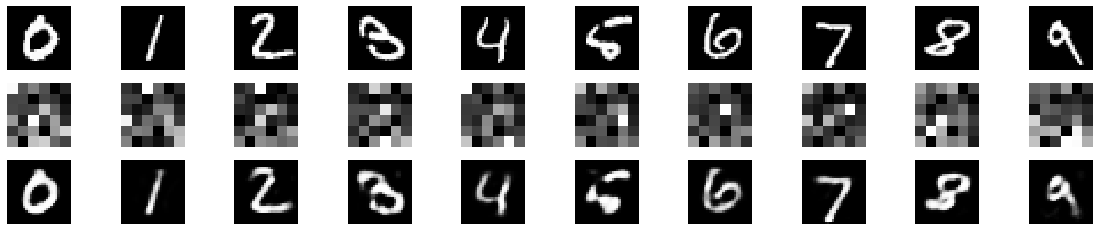

In [25]:
predict_test()

In [26]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

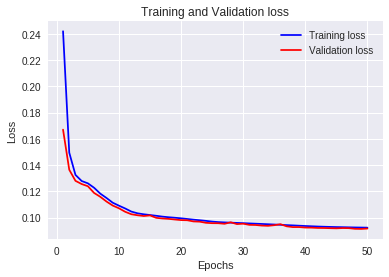

In [27]:
plot_history(history)

In [30]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(10000, 784)

In [31]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(x_test, decoded_imgs)
print(mse)

0.009561755


In [29]:
%load_ext version_information
%version_information keras, tensorflow, numpy , matplotlib

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.4.0 53 generic x86_64 with debian stretch sid
keras 2.1.3
tensorflow 1.4.1
numpy 1.14.0
matplotlib 2.1.2
Thu Jan 25 12:06:06 2018 CST